# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, OneHotEncoder, FunctionTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pkl
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

SEED = 42
np.random.seed(SEED)  


# Read Data

In [2]:
df = pd.read_csv("ObesityDataSet2.csv")
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,24,1.58,65.29,yes,no,2.03,2.74,Sometimes,no,2.00,no,1.28,1.019,no,Public_Transportation,Overweight_Level_II
1,Male,23,1.65,66.00,no,no,3.00,3.00,Sometimes,no,2.00,no,3.00,0.000,no,Public_Transportation,Normal_Weight
2,Female,21,1.69,51.26,yes,yes,3.00,3.18,Frequently,no,1.91,no,0.48,0.625,no,Public_Transportation,Insufficient_Weight
3,Female,22,1.69,65.00,yes,yes,2.00,3.00,Sometimes,no,2.00,no,1.00,1.000,Sometimes,Public_Transportation,Normal_Weight
4,Female,23,1.61,82.64,yes,yes,2.96,1.00,Sometimes,no,2.98,no,0.74,2.000,Sometimes,Public_Transportation,Obesity_Type_I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,Female,21,1.74,130.93,yes,yes,3.00,3.00,Sometimes,no,1.85,no,1.46,0.962,Sometimes,Public_Transportation,Obesity_Type_III
1052,Female,17,1.54,57.26,no,yes,1.97,2.34,Sometimes,no,1.71,yes,0.10,1.191,Sometimes,Public_Transportation,Overweight_Level_I
1053,Female,19,1.60,45.00,no,no,3.00,3.00,no,no,3.00,yes,2.00,0.000,no,Walking,Insufficient_Weight
1054,Female,25,1.69,113.45,yes,yes,3.00,3.00,Sometimes,no,2.99,no,0.39,0.284,Sometimes,Public_Transportation,Obesity_Type_III


df.info()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1056 non-null   object 
 1   Age                             1056 non-null   object 
 2   Height                          1056 non-null   float64
 3   Weight                          1056 non-null   float64
 4   family_history_with_overweight  1056 non-null   object 
 5   FAVC                            1056 non-null   object 
 6   FCVC                            1019 non-null   float64
 7   NCP                             1056 non-null   float64
 8   CAEC                            1056 non-null   object 
 9   SMOKE                           1056 non-null   object 
 10  CH2O                            1056 non-null   float64
 11  SCC                             1056 non-null   object 
 12  FAF                             10

Dari informasi diatas kita dapat melihat beberapa data type yang tidak cocok dengan variablenya seperti Age sebagai object, disini kita dapat melakukan perbaikan data

In [4]:
print(df['Age'].unique())
df[df['Age'] == '20 years'] = 20
df[df['Age'] == '22 years'] = 22
df[df['Age'] == '17 years'] = 17
df[df['Age'] == '25 years'] = 25
df[df['Age'] == '21 years'] = 21
df[df['Age'] == '19 years'] = 19
df[df['Age'] == '36 years'] = 36
df[df['Age'] == '26 years'] = 26
df[df['Age'] == '33 years'] = 33
df[df['Age'] == '23 years'] = 23
df['Age'] = df['Age'].astype(int)
print(df['Age'].unique())

['24' '23' '21' '22' '26' '18' '25' '20' '32' '20 years' '19' '38' '34'
 '44' '39' '22 years' '41' '31' '17 years' '17' '29' '42' '27' '16'
 '25 years' '40' '21 years' '33' '30' '37' '35' '36' '15' '19 years' '28'
 '55' '46' '36 years' '26 years' '45' '33 years' '43' '51' '48' '23 years'
 '14']
[24 23 21 22 26 18 25 20 32 19 38 34 44 39 41 31 17 29 42 27 16 40 33 30
 37 35 36 15 28 55 46 45 43 51 48 14]


Data Sudah Dibenarkan dan kita dapat lanjut ke tahap selanjutnya yaitu mengecek data kosong, data duplikat, dan check outlier

In [5]:
df.isna().sum()

Gender                             0
Age                                0
Height                             0
Weight                             0
family_history_with_overweight     0
FAVC                               0
FCVC                              36
NCP                                0
CAEC                               0
SMOKE                              0
CH2O                               0
SCC                                0
FAF                                0
TUE                                0
CALC                               0
MTRANS                            25
NObeyesdad                         0
dtype: int64

karena FCVC adalah numerical kita harus mengecek boxplot sebelum melakukan imputasi, untuk MTRANS kita dapat menggunakan mode

In [6]:
df.duplicated().sum()

16

In [7]:
df = df.drop_duplicates()

Data kita memiliki 16 data duplikat sehingga harus kita hilangkan karena akan menyebabkan model klasifikasi untuk bias, overfit dan memperlama proses training

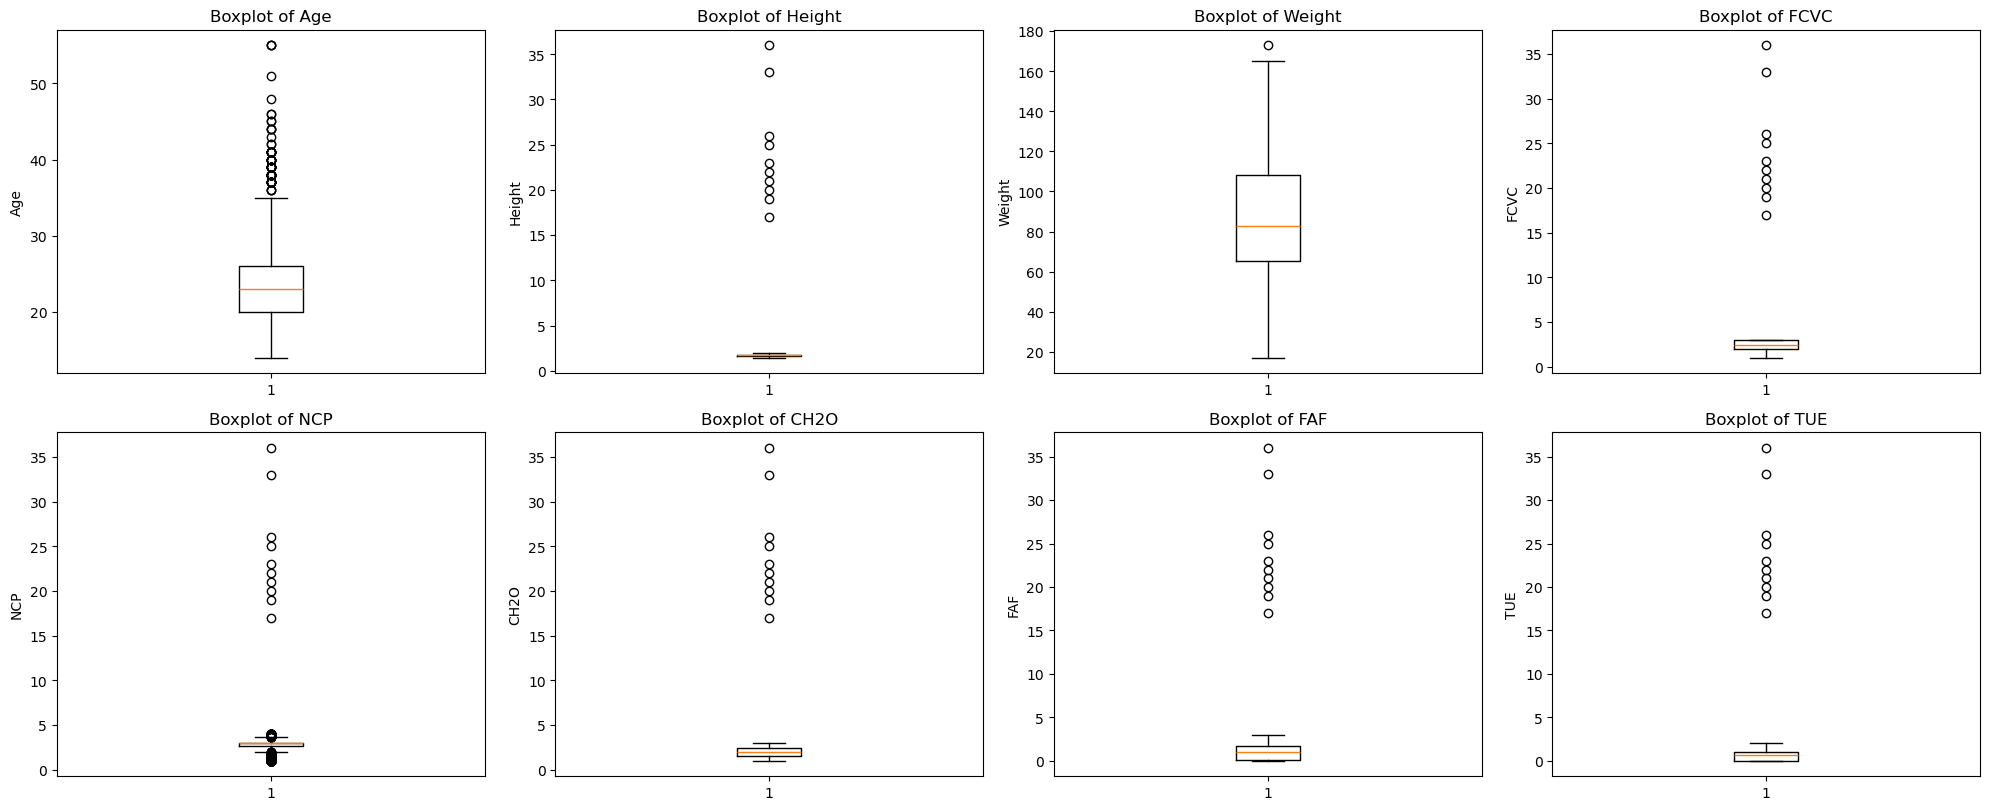

In [8]:
numeric_cols = df.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

for j in range(len(numeric_cols), 12):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Imputation

Dari hasil boxplot diatas dapat dilihat bahwa semua nilai numerical memiliki outlier, insight ini akan membantu kita dalam memilih metode imputasi yang tepat dan menentukan scaler yang optimal untuk model. Karena semua fitur memiliki outlier imputasi yang dilakukan untuk kolom numerical adalah median

In [9]:
df.loc[:, 'FCVC'] = df['FCVC'].fillna(df['FCVC'].median())
df.loc[:, 'MTRANS'] = df['MTRANS'].fillna(df['MTRANS'].mode()[0])

Kita harus melakukan checking apakah fitur categorical lain memiliki anomali dalam data, hal ini terjadi karena data type object yaitu string dapat menyimpan apa saja termausk angka yang dikonversi ke string maka itu kita akan cek data setiap fitur

In [10]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"\n{col} Unique:")
    print(df[col].unique())


Gender Unique:
['Female' 'Male' 20 22 17 25 21 19 36 26 33 23]

family_history_with_overweight Unique:
['yes' 'no' 20 22 17 25 21 19 36 26 33 23]

FAVC Unique:
['no' 'yes' 20 22 17 25 21 19 36 26 33 23]

CAEC Unique:
['Sometimes' 'Frequently' 20 'no' 22 17 'Always' 25 21 19 36 26 33 23]

SMOKE Unique:
['no' 'yes' 20 22 17 25 21 19 36 26 33 23]

SCC Unique:
['no' 20 'yes' 22 17 25 21 19 36 26 33 23]

CALC Unique:
['no' 'Sometimes' 'Frequently' 20 22 'Always' 17 25 21 19 36 26 33 23]

MTRANS Unique:
['Public_Transportation' 'Bike' 20 'Automobile' 'Motorbike' 22 'Walking'
 17 25 21 19 36 26 33 23]

NObeyesdad Unique:
['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_I' 'Obesity_Type_III' 'Overweight_Level_I' 20
 'Obesity_Type_II' 22 17 25 21 19 36 26 33 23]


bisa dilihat banyak anomali pada data sehingga kita akan mengimputasinya menggunakan mode data tersebut

In [11]:
columns = [
    "Gender", "family_history_with_overweight", "FAVC", "CAEC",
    "SMOKE", "SCC", "CALC"
]

for col in columns:
    df.loc[:, col] = df[col].apply(lambda x: x if str(x).isalpha() else None)
    df.loc[:, col] = df[col].fillna(df[col].mode()[0])

valid_mtrans = ["Public_Transportation", "Automobile", "Walking", "Motorbike", "Bike"]
valid_nobeyesdad = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]

df.loc[:, 'MTRANS'] = df['MTRANS'].apply(lambda x: x if x in valid_mtrans else None)
df.loc[:, 'MTRANS'] = df['MTRANS'].fillna(df['MTRANS'].mode()[0])

df.loc[:, 'NObeyesdad'] = df['NObeyesdad'].apply(lambda x: x if x in valid_nobeyesdad else None)
df.loc[:, 'NObeyesdad'] = df['NObeyesdad'].fillna(df['NObeyesdad'].mode()[0])

Setelah imputasi selesai dan data sudah bersih kita akan mengecek apakah data dependent memiliki imbalance

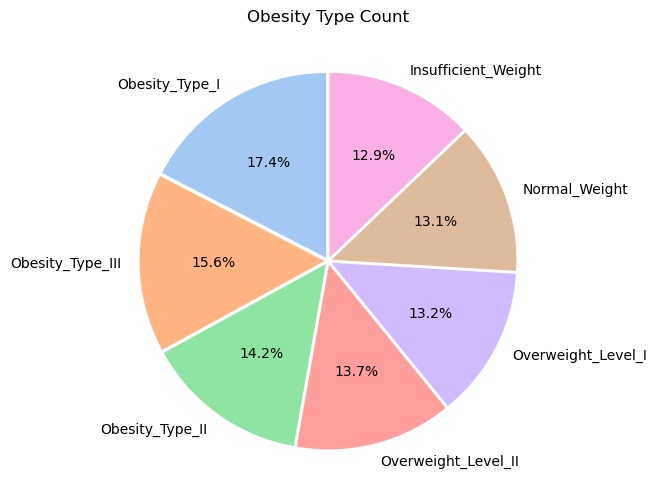

In [12]:
data = df['NObeyesdad'].value_counts()
label = data.index

colors = sns.color_palette('pastel', len(label))

plt.figure(figsize = (8,6))
plt.pie(data, labels = label, autopct = '%1.1f%%',
        explode = [0.02] * len(label),
        startangle = 90,
        colors = colors)
plt.title('Obesity Type Count')
plt.show()

Dari hasil graph kita bisa lihat bahwa data imbalanced untuk menanganinya kita bisa menggunakan model yang robust terhadap imbalanced data seperti catboost, xgboost dan random forest

# Splitting the data

In [13]:
X = df.drop('NObeyesdad', axis = 1)
y = df['NObeyesdad']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

# Data Augmentation

In [15]:
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_cols = ['Gender',  'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
ordinal_cols = ['CAEC', 'CALC']
cat_cols = ['MTRANS']

## ML Pipeline

In [16]:
num_transformer = RobustScaler()

def map_binary(df):
    binary_map = {'yes': 1, 'no': 0}
    gender_map = {'Female': 0, 'Male': 1}
    return df.apply(lambda col: col.map(gender_map if col.name == 'Gender' else binary_map))

binary_transformer = FunctionTransformer(map_binary, feature_names_out="one-to-one")

CAEC_order = ['no', 'Sometimes', 'Frequently', 'Always']
CALC_order = ['no', 'Sometimes', 'Frequently', 'Always']
X_col_order = [CALC_order, CAEC_order] 

ordinal_transformer = OrdinalEncoder(categories=X_col_order)

ohe_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('binary', binary_transformer, binary_cols),
    ('ordinal', ordinal_transformer, ordinal_cols),
    ('cat', ohe_transformer, cat_cols)
])

full_pipeline = Pipeline([
    ('preprocess', preprocessor)
])

X_train_final = full_pipeline.fit_transform(X_train)
X_test_final = full_pipeline.transform(X_test)

NObeyesdad_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'] 
y_encoder = OrdinalEncoder(categories=[NObeyesdad_order])
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

Saya menggunakan 3 tipe encoding untuk kolom categorical karena ada yang memiliki value binary, ordinal dan adapun yang tidak memiliki hirarki sebab itu saya menggunakan mapping, OrdinalEncoder dan OHE untuk encoding. Untuk scaling saya menggunakan robustscaler karena seperti boxplot yang telah saya buat banyak sekali kolom numerical yang memiliki outlier maka itu saya menggunakan robustscaling. Semua ini sudah dimasukkan ke dalam satu pipeline, selain dependent variable yang hanya merupakan 1 kolom sehingga tidak memerlukan pipeline tersendirinya dan bisa langsung di transform saja

# Modelling

In [17]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train_final, y_train_final)

RandomForestClassifier()

In [18]:
y_pred_test = forest_model.predict(X_test_final)
y_pred_train = forest_model.predict(X_train_final)

print("Train Evaluation: ")
print(classification_report(y_train_final, y_pred_train, target_names=NObeyesdad_order))

print("Test Evaluation: ")
print(classification_report(y_test_final, y_pred_test, target_names=NObeyesdad_order))

Train Evaluation: 
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        99
      Normal_Weight       1.00      1.00      1.00       112
 Overweight_Level_I       1.00      1.00      1.00       115
Overweight_Level_II       1.00      1.00      1.00       109
     Obesity_Type_I       1.00      1.00      1.00       144
    Obesity_Type_II       1.00      1.00      1.00       121
   Obesity_Type_III       1.00      1.00      1.00       132

           accuracy                           1.00       832
          macro avg       1.00      1.00      1.00       832
       weighted avg       1.00      1.00      1.00       832

Test Evaluation: 
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.97      0.99        35
      Normal_Weight       0.71      0.92      0.80        24
 Overweight_Level_I       0.90      0.86      0.88        22
Overweight_Level_II       0.97      0.85    

In [19]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_final, y_train_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [20]:
y_pred_test = xgb_model.predict(X_test_final)
y_pred_train = xgb_model.predict(X_train_final)

print("Train Evaluation: ")
print(classification_report(y_train_final, y_pred_train, target_names=NObeyesdad_order))

print("Test Evaluation: ")
print(classification_report(y_test_final, y_pred_test, target_names=NObeyesdad_order))

Train Evaluation: 
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        99
      Normal_Weight       1.00      1.00      1.00       112
 Overweight_Level_I       1.00      1.00      1.00       115
Overweight_Level_II       1.00      1.00      1.00       109
     Obesity_Type_I       1.00      1.00      1.00       144
    Obesity_Type_II       1.00      1.00      1.00       121
   Obesity_Type_III       1.00      1.00      1.00       132

           accuracy                           1.00       832
          macro avg       1.00      1.00      1.00       832
       weighted avg       1.00      1.00      1.00       832

Test Evaluation: 
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.94      0.96        35
      Normal_Weight       0.91      0.83      0.87        24
 Overweight_Level_I       0.81      0.95      0.88        22
Overweight_Level_II       1.00      0.97    

In [21]:
importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                   Feature  Importance
8                           binary__Gender    0.404688
2                              num__Weight    0.168117
1                              num__Height    0.066207
15                  cat__MTRANS_Automobile    0.051245
10                            binary__FAVC    0.034280
14                           ordinal__CALC    0.032502
7                                 num__TUE    0.030519
13                           ordinal__CAEC    0.029971
6                                 num__FAF    0.029245
0                                 num__Age    0.028625
5                                num__CH2O    0.028162
12                             binary__SCC    0.024911
3                                num__FCVC    0.024008
4                                 num__NCP    0.020264
18       cat__MTRANS_Public_Transportation    0.016578
9   binary__family_history_with_overweight    0.010678
11                           binary__SMOKE    0.000000
16        

# Kesimpulan

Dari hasil kedua model diatas kita dapat melihat bahwa randomforest dan XGB memiliki kemampuan memprediksi yang hampir sama, jika dilihat random forest memiliki presisi yang jauh lebih rendah dibanding model xgboost dimana model random forest banyak melakukan kesalahan prediksi suatu kelas tetapi prediksi kelas tersebut tidak sama dengan data aslinya sehingga dapat disimpulkan bahwa model xgb lebih stabil dalam melakukan prediksi kelas obesity. maka itu model yang lebih baik untuk digunakan adalah xgbclassifier. Dari feature importance diatas juga dapat dilihat bahwa fitur Gender memiliki pengaruh terbesar dalam menentukan obesitas selain itu weight juga memiliki pengaruh terhadap hasil model.

# Pickling

In [22]:
modelfile = "model.pkl"
pkl.dump(xgb_model, open(modelfile, 'wb'))

X_pipeline = "X_pipeline.pkl"
pkl.dump(full_pipeline, open(X_pipeline, 'wb'))

y_encoders={
    "y_encoder": y_encoder,
}

y_encodefile = "y_encode.pkl"
pkl.dump(y_encoders, open(y_encodefile, 'wb'))
